In [1]:
import numpy as np
import h5py
from sklearn.metrics import roc_auc_score
import matplotlib.pyplot as plt
import time
from math import fabs, sqrt, log, exp, factorial

In [2]:
def bound(N, loss, L, comb_dict):
    '''
    Calculate annoying parameters to estimate rho
    '''

    R1 = 0.0
    R2 = 0.0
    Sp1 = 0.0
    Sm1 = 0.0
    Sp2 = 0.0
    Sm2 = 0.0
    for i in range(N + 1):
        # compute plus
        alpha0 = L ** i
        alpha1 = i * L ** (i - 1)
        alpha2 = i * (i - 1) * L ** (i - 2)
        R1 += alpha0
        Sp1 += alpha1
        Sp2 += alpha2
        # compute minus
        beta0 = 0.0
        beta1 = 0.0
        beta2 = 0.0
        for k in range(i, N + 1):
            # compute forward difference
            delta = 0.0
            for j in range(k + 1):
                delta += comb_dict[k][j] * (-1) ** (k - j) * loss(j / N)
            # compute coefficient
            beta0 += comb_dict[N][k] * comb_dict[k][i] * (N + 1) * fabs(delta) / (2 ** k) / (L ** i)
            beta1 += comb_dict[N][k] * comb_dict[k][i] * (N + 1) * (k - i) * fabs(delta) / (2 ** k) / (L ** (i + 1))
            beta2 += comb_dict[N][k] * comb_dict[k][i] * (N + 1) * (k - i) * (k - i - 1) * fabs(delta) / (2 ** k) / (
                        L ** (i + 2))
        R2 += beta0
        Sm1 += beta1
        Sm2 += beta2

    gamma = max((2 * R1 + R2) * Sp2 + Sp1 ** 2, (2 * R2 + R1) * Sm2 + Sm1 ** 2) / (N + 1)

    return R1, R2, gamma

In [3]:
def bern_loss_func(name, L):
    
    '''
    Define loss function

    input:
        name - name of loss funtion
        L - bound for prod

    output:
        loss - loss function
    '''
    
    if name == 'hinge':
        loss = lambda x: max(0, 1 + L - 2 * L * x)
    elif name == 'logistic':
        loss = lambda x: log(1 + exp(L - 2 * L * x))
    else:
        print('Wrong loss function!')

    return loss

In [4]:
def pos(prod,L):
    '''
    Compute positive function and gradient information
    
    input:
        t - iteration
        prod - wt*xt
        
    output:
        fpt - positive function value
        gfpt - positive function gradient
        wasted - time wasted on computing
    '''
    
    start = time.time()
    
    plus = L/2+prod
    p = list(range(N+1))
    fpt = np.power(plus,p)
    gfpt = np.multiply(fpt,p)/plus # no xt yet!
    
    wasted = time.time() - start
    
    return fpt,gfpt,wasted              

In [5]:
def comb(N):
    '''
    Compute combination
    
    input:
        N - degree of Bernstein
    
    output:
        c - combination dictionary
    '''
    
    c = {}
    for n in range(N+1):
        c[n] = np.zeros(n+1)
        for k in range(n+1):
            c[n][k] = factorial(n) / factorial(k) / factorial(n-k)
    return c

In [6]:
def coef(N,loss,L,comb_dict):
    
    '''
    Compute the coefficient first
    
    input:
        N - degree of Bernstein
        loss - loss function
        L - 
        comb_dict - 
        
    output:
        beta - coefficient dictionary
        gbeta - gradient coefficient dictionary
    '''
    
    beta = {}
    gbeta = {}
    for i in range(N+1):
        beta[i] = np.zeros(N-i+1)
        gbeta[i] = np.zeros(N-i+1)
        for k in range(i,N+1):
            # compute forward difference
            delta = 0.0
            for j in range(k+1):
                delta += comb_dict[k][j]*(-1)**(k-j)*loss(j/N)
            # compute coefficient
            beta[i][k-i] = comb_dict[N][k]*comb_dict[k][i]*(N+1)*delta/((2*L)**k)
            gbeta[i][k-i] = beta[i][k-i]*(k-i)
            
    return beta, gbeta

In [7]:
def neg(N,loss,prod,L,beta,gbeta):
    '''
    Compute negative function and gradient information
    
    input:
        N - 
        loss - loss function
        prod - wt*xt
        L - 
        beta - coefficient
        
    output:
        fnt - negative function value
        gfnt - negative function gradient
        wasted - time wasted on computing
    '''
    
    start = time.time()
    
    minus = L/2-prod
    p = list(range(N+1))
    # exponent
    exponent = np.power(minus,p)
    
    fnt = np.zeros(N+1)
    gfnt = np.zeros(N+1)
    
    for i in range(N+1):
        # compute function value
        fnt[i] = np.inner(beta[i],exponent[:N-i+1])
    
        # compute gradient
        gfnt[i] = np.inner(gbeta[i],exponent[:N-i+1])/minus  # no xt yet!
    
    wasted = time.time() - start
    
    return fnt,gfnt,wasted

In [8]:
def w_grad(gfpt,gfnt,yt,at,bt,alphat):
    '''
    Gradient with respect to w
    
    input:
        fpt - positive function at t
        gfpt - positive function gradient at t
        fnt - negative function at t
        gfnt - negative function gradient at t
        yt - sample label at t
        pt - p at t
        at - a at t
        bt - b at t
        alphat - alpha at t
    output:
        gradwt - gradient w.r.t. w at t
    '''
    if yt == 1:
        gradwt = 2*(alphat - at)*gfpt
    else:
        gradwt = 2*(alphat - bt)*gfnt
    return gradwt

In [9]:
def proj(x,R):
    '''
    Projection
    
    input:
        x - 
        R - radius
        
    output:
        proj - projected 
    '''
    norm = np.linalg.norm(x)
    if norm > R:
        x = x/norm*R
    return x

In [10]:
def a_grad(fpt,yt,at):
    '''
    Gradient with respect to a
    
    input:
        fpt - positive function at t
        yt - sample label at t
        pt - p at t
        at - a at t
    
    output:
        gradat - gradient w.r.t a at t
    '''
    gradat = 0.0 
    if yt == 1:
        gradat = 2*(at - fpt)
    else:
        gradat = 2*at
    return gradat

In [11]:
def b_grad(fnt,yt,bt):
    '''
    Gradient with respect to b
    
    input:
        fnt - negative function at t
        yt - sample label at t
        pt - p at t
        bt - b at t
    
    output:
        gradbt - gradient w.r.t b at t
    '''
    gradbt = 0.0 
    if yt == 1:
        gradbt = 2*bt
    else:
        gradbt = 2*(bt - fnt)
    return gradbt

In [12]:
def alpha_grad(fpt,fnt,yt,alphat):
    '''
    Gradient with respect to alpha
    '''
    gradalphat = 0.0
    if yt == 1:
        gradalphat = -2*(alphat - fpt)
    else:
        gradalphat = -2*(alphat - fnt)
    return gradalphat

In [13]:
def prox(N, eta, loss, index, X, Y, L, R1, R2, gamma, beta, gbeta, wj, aj, bj, alphaj, bwt):
    '''
    perform proximal guided gradient descent when receive an sample

    input:
        N - 
        eta - step size
        loss - loss function
        index -
        X - sample features
        Y - sample labels
        L -
        R1 -
        R2 -
        gamma - weakly convex coefficient
        wj -
        aj -
        bj -
        alphaj -
        bwt -

    output:
        wj - w at jth step
        aj -
        bj -
        alphaj -
        wasted - time wasted on computing
    '''

    prod = np.dot(wj, X[index])
    wasted = 0.0
    
    fpt, gfpt, _ = pos(prod,L)
    wasted += _
    fnt, gfnt, _ = neg(N,loss,prod,L,beta,gbeta)
    wasted += _
    
    if Y[index] == 1:
        gradwt = 2*np.inner(alphaj - aj, gfpt)
        gradat = 2*(aj - fpt)
        gradbt = 2*bj
        gradalphat = -2*(alphaj - fpt)
    else:
        gradwt = 2*np.inner(alphaj - bj, gfnt)
        gradat = 2*aj
        gradbt = 2*(bj - fnt)
        gradalphat = -2*(alphaj - fnt)
        
    wj = wj - eta * (gradwt * X[index] * Y[index] / (2 * (N + 1)) + gamma * (wj - bwt))
    aj = aj - eta * gradat / (2 * (N + 1))
    bj = bj - eta * gradbt / (2 * (N + 1))
    alphaj = alphaj + eta * gradalphat / (2 * (N + 1))

    wj = proj(wj, L / 2)
    aj = proj(aj, R1)
    bj = proj(bj, R2)
    alphaj = proj(alphaj, R1 + R2)

    return wj, aj, bj, alphaj, wasted

In [14]:
def PGSPD(N, t, loss, passing_list, X, Y, L, R1, R2, gamma, c, beta, gbeta, bwt, bat, bbt, balphat):

    '''
    Proximally Guided Stochastic Primal Dual Inner loop

    input:
        N - 
        t - iteration at t
        loss - loss function
        passing_list
        X -
        Y -
        L -
        R1 -
        R2 -
        gamma -
        c -
        bwt - last outer loop w
        bat - last outer loop a
        bbt - last outer loop b
        balphat - last outer loop alpha

    output:
        bwt - next outer loop w
        bat - next outer loop a
        bbt - next outer loop b
        balphat - next outer loop alpha
        wasted - time wasted on computing
    '''
    
    wasted = 0.0
    # initialize inner loop variables
    Wt = bwt + 0.0
    At = bat + 0.0
    Bt = bbt + 0.0
    ALPHAt = balphat + 0.0

    BWt = 0.0
    BAt = 0.0
    BBt = 0.0
    BALPHAt = 0.0

    ETAt = c / sqrt(t) / gamma
    
    # t = min(t,100)

    # inner loop update at j
    for j in range(t):
        # update inner loop variables
        Wt, At, Bt, ALPHAt, _ = prox(N, ETAt, loss, passing_list[j], X, Y, L, R1, R2, gamma, beta, gbeta, Wt, At, Bt, ALPHAt, bwt)
        wasted += _
        
        BWt += Wt
        BAt += At
        BBt += Bt
        BALPHAt += ALPHAt

    # update outer loop variables
    bwt = BWt / t
    bat = BAt / t
    bbt = BBt / t
    balphat = BALPHAt / t

    return bwt, bat, bbt, balphat, wasted

In [15]:
def SAUC(T,name,N,L,c,Xtr,Ytr,Xte,Yte,stamp = 10):
    '''
    Stochastic AUC Optimization with General Loss

    input:
        T -
        name -
        N - Bernstein degree
        L - Bound for prod
        c - step size parameter
        Xtr - Training features
        Ytr - Training labels
        Xte - Testing features
        Yte - Testing labels
        stamp - record stamp

    output:
        elapsed_time -
        roc_auc - auc scores
    '''
    
    sum_time = 0.0
    
    wasted = 0.0 
    
    print('SAUC......')
    
    # get the dimension of what we are working with
    n, d = Xtr.shape

    WT = np.zeros(d)
    AT = np.zeros(N + 1)
    BT = np.zeros(N + 1)
    ALPHAT = np.zeros(N + 1)
    
    # define loss function
    loss = bern_loss_func(name, L)
    
    # compute combination and coefficient
    comb_dict = comb(N)
    beta,gbeta = coef(N,loss,L,comb_dict)

    # compute gamma(get it done, bitch!)
    R1, R2, gamma = bound(N,loss,L,comb_dict)

    # record auc
    roc_auc = []

    # record time elapsed
    elapsed_time = []
    start_time = time.time()

    # Begin algorithm
    for t in range(1, T + 1):

        # Prepare the indices if you know what I mean
        prep_time = time.time()
        epoch = t // n
        begin = (t * (t - 1) // 2) % n
        end = (t * (t + 1) // 2) % n
        if epoch < 1:
            if begin < end:
                tr_list = [i for i in range(begin, end)]
            else:  # need to think better
                tr_list = [i for i in range(begin, n)] + [i for i in range(end)]
        else:
            if begin < end:
                tr_list = [i for i in range(begin, n)] + [i for i in range(n)] * (epoch - 1) + [i for i in range(end)]
            else:
                tr_list = [i for i in range(begin, n)] + [i for i in range(n)] * epoch + [i for i in range(end)]
        sum_time += time.time() - prep_time
        # Inner loop
        WT, AT, BT, ALPHAT, _ = PGSPD(N, t, loss, tr_list, Xtr, Ytr, L, R1, R2, gamma, c, beta, gbeta, WT, AT, BT, ALPHAT)
        wasted += _
        if t % stamp == 0:
            elapsed_time.append(time.time() - start_time - sum_time - wasted)
            roc_auc.append(roc_auc_score(Yte, np.dot(Xte, WT)))
            print('gamma: %.2f c: %.2f iteration: %d AUC: %.6f time eplapsed: %.2f/%.2f' % (gamma, c, t, roc_auc[-1], elapsed_time[-1],wasted))

            sum_time = 0.0
            # start_time = time.time()

    return elapsed_time, roc_auc

In [16]:
def loss_func(name):
    '''
    Define loss function

    input:
        name - name of loss function

    output:
        loss - loss function
    '''

    if name == 'hinge':
        loss = lambda x: max(0, 1 - x)
    elif name == 'logistic':
        loss = lambda x: log(1 + exp(-x))
    else:
        print('Wrong loss function!')

    return loss

In [17]:
def reservior(Bt,xt,N,M):
    '''
    Reservior Sampling

    input:
        Bt - current buffer
        xt - a training instance
        N - the buffer size
        M - the number of instances received till trial t

    output:
        Bt - updated buffer
    '''

    L = len(Bt)
    if L < N:
        Bt.append(xt)
    else:
        z = np.random.binomial(1, p=N/M)
        if z == 1:
            ind = np.random.randint(L)
            Bt[ind] = xt

    return Bt

In [18]:
def seq(loss,wt,xt,yt,B,ct):
    '''
    Sequential update

    input:
        grad - gradient of loss function
        wt - the current classifier
        xt -
        yt -
        B - the buffer to be compared to
        ct - a parameter that weights the comparison

    output:
        wt - th updated classifier
    '''
    L = len(B)
    for i in range(L):
        prod = np.inner(wt,xt - B[i])
        norm = np.inner(xt - B[i],xt - B[i])
        tau = min(ct/2,loss(prod*yt)/norm)
        wt += tau*yt*(xt - B[i])

    return wt

In [19]:
def gra(wt,xt,yt,B,ct):
    '''
    gradient updating

    input:
        wt - the current classifier
        xt -
        yt -
        B - the bufferto be compared to
        ct - a parameter that weights the comparison

    output:
        wt - th updated classifier
    '''
    L = len(B)
    w = wt + 0.0
    for i in range(L):
        prod = np.inner(w,xt - B[i])
        if yt*prod <= 1:
            wt += ct*yt*(xt - B[i])/2

    return wt

In [20]:
def OAM(T,name,option,c,Np,Nn,Xtr,Ytr,Xte,Yte,stamp = 10):
    '''
    Online AUC Maximization

    input:
        T -
        name -
        option - update option
        c - penalty parameter
        Np - maximum buffer size of positive samples
        Nn - maximum buffer size of negative samples
        Xtr -
        Ytr -
        Xte -
        Yte -
        stamp - record stamp

    output:
        elapsed_time -
        roc_auc - auc scores
    '''

    print('OAM......')

    # get the dimension of what we are working with
    n, d = Xtr.shape

    # define loss function
    loss = loss_func(name)

    # initialize
    wt = np.zeros(d)
    Bpt = []
    Bnt = []
    Npt = 0
    Nnt = 0
    # record auc
    roc_auc = []

    # record time elapsed
    elapsed_time = []
    start_time = time.time()

    for t in range(1,T+1):
        if Ytr[t%n] == 1:
            Npt += 1
            ct = c*max(1,Nnt/Nn)
            Bpt = reservior(Bpt,Xtr[t%n],Np,Npt)
            if option == 'sequential':
                wt = seq(loss,wt,Xtr[t%n],Ytr[t%n],Bnt,ct)
            elif option == 'gradient':
                wt = gra(wt, Xtr[t % n], Ytr[t % n], Bnt, ct)
            else:
                print('Wrong update option!')
                return
        else:
            Nnt += 1
            ct = c*max(1,Npt/Np)
            Bnt = reservior(Bnt,Xtr[t%n],Nn,Nnt)
            if option == 'sequential':
                wt = seq(loss,wt,Xtr[t%n],Ytr[t%n],Bpt,ct)
            elif option == 'gradient':
                wt = gra(wt, Xtr[t % n], Ytr[t % n], Bpt, ct)
            else:
                print('Wrong update option!')
                return

        if t % stamp == 0:
            elapsed_time.append(time.time() - start_time)
            roc_auc.append(roc_auc_score(Yte, np.dot(Xte, wt)))
            print('c: %.2f iteration: %d AUC: %.6f time eplapsed: %.2f' % (c, t, roc_auc[-1], elapsed_time[-1]))

            # start_time = time.time()

    return elapsed_time, roc_auc

In [113]:
# Read data from hdf5 file
dataset = 'svmguide1'
hf = h5py.File('/home/neyo/PycharmProjects/AUC/datasets/%s.h5' % (dataset), 'r')
FEATURES = hf['FEATURES'][:]
LABELS = hf['LABELS'][:]
hf.close()

In [105]:
# Define hyper parameters
N = 5
T = [500,1000]
folders = 2
stamp = [1,1]

In [106]:
# Define model parameters
L = [2]
C = [1,10]
Np = [100]
Nn = [100]

In [107]:
# Define losses and algorithms
NAME = ['hinge','logistic']
ALG = ['SAUC','OAM']
OPTION = ['sequential','gradient']

In [111]:
# Prepare training and testing
n = len(LABELS)
testing = [i for i in range(n // 2)]
training = [i for i in range(n // 2, n)]

In [114]:
# Prepare results
res = {}
for name in NAME:
    for alg in ALG:
        if alg == 'SAUC':
            res[(name,alg)] = SAUC(T[0],name,N,L[0],C[0],FEATURES[training],LABELS[training],FEATURES[testing],LABELS[testing],stamp = stamp[0])
        else:
            for option in OPTION:
                res[(name,alg+'_'+option)] = OAM(T[1],name,option,C[1],Np[0],Nn[0],FEATURES[training],LABELS[training],FEATURES[testing],LABELS[testing],stamp = stamp[1])

SAUC......
gamma: 8837.74 c: 1.00 iteration: 1 AUC: 0.500000 time eplapsed: 0.00/0.00
gamma: 8837.74 c: 1.00 iteration: 2 AUC: 0.500000 time eplapsed: 0.00/0.00
gamma: 8837.74 c: 1.00 iteration: 3 AUC: 0.811248 time eplapsed: 0.01/0.00
gamma: 8837.74 c: 1.00 iteration: 4 AUC: 0.639098 time eplapsed: 0.01/0.00
gamma: 8837.74 c: 1.00 iteration: 5 AUC: 0.864306 time eplapsed: 0.01/0.00
gamma: 8837.74 c: 1.00 iteration: 6 AUC: 0.864822 time eplapsed: 0.01/0.00
gamma: 8837.74 c: 1.00 iteration: 7 AUC: 0.861587 time eplapsed: 0.01/0.00
gamma: 8837.74 c: 1.00 iteration: 8 AUC: 0.863311 time eplapsed: 0.02/0.00
gamma: 8837.74 c: 1.00 iteration: 9 AUC: 0.863186 time eplapsed: 0.02/0.01
gamma: 8837.74 c: 1.00 iteration: 10 AUC: 0.860396 time eplapsed: 0.02/0.01
gamma: 8837.74 c: 1.00 iteration: 11 AUC: 0.861213 time eplapsed: 0.02/0.01
gamma: 8837.74 c: 1.00 iteration: 12 AUC: 0.857534 time eplapsed: 0.02/0.01
gamma: 8837.74 c: 1.00 iteration: 13 AUC: 0.856325 time eplapsed: 0.03/0.01
gamma: 883

gamma: 8837.74 c: 1.00 iteration: 112 AUC: 0.856770 time eplapsed: 0.51/0.31
gamma: 8837.74 c: 1.00 iteration: 113 AUC: 0.856770 time eplapsed: 0.51/0.34
gamma: 8837.74 c: 1.00 iteration: 114 AUC: 0.856787 time eplapsed: 0.52/0.34
gamma: 8837.74 c: 1.00 iteration: 115 AUC: 0.856787 time eplapsed: 0.53/0.35
gamma: 8837.74 c: 1.00 iteration: 116 AUC: 0.856770 time eplapsed: 0.54/0.35
gamma: 8837.74 c: 1.00 iteration: 117 AUC: 0.856787 time eplapsed: 0.55/0.36
gamma: 8837.74 c: 1.00 iteration: 118 AUC: 0.856770 time eplapsed: 0.55/0.36
gamma: 8837.74 c: 1.00 iteration: 119 AUC: 0.856787 time eplapsed: 0.56/0.37
gamma: 8837.74 c: 1.00 iteration: 120 AUC: 0.856787 time eplapsed: 0.57/0.37
gamma: 8837.74 c: 1.00 iteration: 121 AUC: 0.856787 time eplapsed: 0.58/0.38
gamma: 8837.74 c: 1.00 iteration: 122 AUC: 0.856770 time eplapsed: 0.58/0.38
gamma: 8837.74 c: 1.00 iteration: 123 AUC: 0.856787 time eplapsed: 0.59/0.39
gamma: 8837.74 c: 1.00 iteration: 124 AUC: 0.856787 time eplapsed: 0.60/0.39

gamma: 8837.74 c: 1.00 iteration: 222 AUC: 0.856787 time eplapsed: 1.66/1.03
gamma: 8837.74 c: 1.00 iteration: 223 AUC: 0.856752 time eplapsed: 1.67/1.04
gamma: 8837.74 c: 1.00 iteration: 224 AUC: 0.856770 time eplapsed: 1.69/1.05
gamma: 8837.74 c: 1.00 iteration: 225 AUC: 0.856752 time eplapsed: 1.70/1.05
gamma: 8837.74 c: 1.00 iteration: 226 AUC: 0.856770 time eplapsed: 1.71/1.06
gamma: 8837.74 c: 1.00 iteration: 227 AUC: 0.856787 time eplapsed: 1.72/1.07
gamma: 8837.74 c: 1.00 iteration: 228 AUC: 0.856787 time eplapsed: 1.73/1.07
gamma: 8837.74 c: 1.00 iteration: 229 AUC: 0.856787 time eplapsed: 1.75/1.08
gamma: 8837.74 c: 1.00 iteration: 230 AUC: 0.856787 time eplapsed: 1.76/1.09
gamma: 8837.74 c: 1.00 iteration: 231 AUC: 0.856770 time eplapsed: 1.77/1.10
gamma: 8837.74 c: 1.00 iteration: 232 AUC: 0.856770 time eplapsed: 1.78/1.10
gamma: 8837.74 c: 1.00 iteration: 233 AUC: 0.856770 time eplapsed: 1.80/1.12
gamma: 8837.74 c: 1.00 iteration: 234 AUC: 0.856752 time eplapsed: 1.81/1.12

gamma: 8837.74 c: 1.00 iteration: 329 AUC: 0.856752 time eplapsed: 3.24/2.05
gamma: 8837.74 c: 1.00 iteration: 330 AUC: 0.856752 time eplapsed: 3.26/2.06
gamma: 8837.74 c: 1.00 iteration: 331 AUC: 0.856752 time eplapsed: 3.28/2.07
gamma: 8837.74 c: 1.00 iteration: 332 AUC: 0.856752 time eplapsed: 3.30/2.08
gamma: 8837.74 c: 1.00 iteration: 333 AUC: 0.856752 time eplapsed: 3.31/2.09
gamma: 8837.74 c: 1.00 iteration: 334 AUC: 0.856752 time eplapsed: 3.33/2.11
gamma: 8837.74 c: 1.00 iteration: 335 AUC: 0.856770 time eplapsed: 3.35/2.12
gamma: 8837.74 c: 1.00 iteration: 336 AUC: 0.856770 time eplapsed: 3.37/2.13
gamma: 8837.74 c: 1.00 iteration: 337 AUC: 0.856752 time eplapsed: 3.39/2.14
gamma: 8837.74 c: 1.00 iteration: 338 AUC: 0.856770 time eplapsed: 3.40/2.15
gamma: 8837.74 c: 1.00 iteration: 339 AUC: 0.856770 time eplapsed: 3.42/2.16
gamma: 8837.74 c: 1.00 iteration: 340 AUC: 0.856752 time eplapsed: 3.44/2.20
gamma: 8837.74 c: 1.00 iteration: 341 AUC: 0.856752 time eplapsed: 3.46/2.21

gamma: 8837.74 c: 1.00 iteration: 440 AUC: 0.856770 time eplapsed: 5.72/3.58
gamma: 8837.74 c: 1.00 iteration: 441 AUC: 0.856770 time eplapsed: 5.75/3.60
gamma: 8837.74 c: 1.00 iteration: 442 AUC: 0.856770 time eplapsed: 5.77/3.61
gamma: 8837.74 c: 1.00 iteration: 443 AUC: 0.856770 time eplapsed: 5.80/3.63
gamma: 8837.74 c: 1.00 iteration: 444 AUC: 0.856770 time eplapsed: 5.83/3.65
gamma: 8837.74 c: 1.00 iteration: 445 AUC: 0.856770 time eplapsed: 5.85/3.66
gamma: 8837.74 c: 1.00 iteration: 446 AUC: 0.856770 time eplapsed: 5.88/3.68
gamma: 8837.74 c: 1.00 iteration: 447 AUC: 0.856770 time eplapsed: 5.91/3.70
gamma: 8837.74 c: 1.00 iteration: 448 AUC: 0.856770 time eplapsed: 5.93/3.71
gamma: 8837.74 c: 1.00 iteration: 449 AUC: 0.856770 time eplapsed: 5.96/3.73
gamma: 8837.74 c: 1.00 iteration: 450 AUC: 0.856770 time eplapsed: 5.99/3.74
gamma: 8837.74 c: 1.00 iteration: 451 AUC: 0.856770 time eplapsed: 6.02/3.76
gamma: 8837.74 c: 1.00 iteration: 452 AUC: 0.856770 time eplapsed: 6.04/3.78

c: 10.00 iteration: 112 AUC: 0.860200 time eplapsed: 0.15
c: 10.00 iteration: 113 AUC: 0.639489 time eplapsed: 0.15
c: 10.00 iteration: 114 AUC: 0.865408 time eplapsed: 0.16
c: 10.00 iteration: 115 AUC: 0.875184 time eplapsed: 0.16
c: 10.00 iteration: 116 AUC: 0.752324 time eplapsed: 0.16
c: 10.00 iteration: 117 AUC: 0.748414 time eplapsed: 0.16
c: 10.00 iteration: 118 AUC: 0.816509 time eplapsed: 0.16
c: 10.00 iteration: 119 AUC: 0.845962 time eplapsed: 0.16
c: 10.00 iteration: 120 AUC: 0.742086 time eplapsed: 0.17
c: 10.00 iteration: 121 AUC: 0.833733 time eplapsed: 0.17
c: 10.00 iteration: 122 AUC: 0.786487 time eplapsed: 0.17
c: 10.00 iteration: 123 AUC: 0.833733 time eplapsed: 0.17
c: 10.00 iteration: 124 AUC: 0.860111 time eplapsed: 0.17
c: 10.00 iteration: 125 AUC: 0.855045 time eplapsed: 0.17
c: 10.00 iteration: 126 AUC: 0.745481 time eplapsed: 0.18
c: 10.00 iteration: 127 AUC: 0.830356 time eplapsed: 0.18
c: 10.00 iteration: 128 AUC: 0.734514 time eplapsed: 0.18
c: 10.00 itera

c: 10.00 iteration: 320 AUC: 0.855205 time eplapsed: 0.56
c: 10.00 iteration: 321 AUC: 0.868128 time eplapsed: 0.56
c: 10.00 iteration: 322 AUC: 0.835351 time eplapsed: 0.56
c: 10.00 iteration: 323 AUC: 0.841003 time eplapsed: 0.57
c: 10.00 iteration: 324 AUC: 0.855828 time eplapsed: 0.57
c: 10.00 iteration: 325 AUC: 0.827672 time eplapsed: 0.57
c: 10.00 iteration: 326 AUC: 0.841181 time eplapsed: 0.57
c: 10.00 iteration: 327 AUC: 0.498587 time eplapsed: 0.57
c: 10.00 iteration: 328 AUC: 0.814483 time eplapsed: 0.58
c: 10.00 iteration: 329 AUC: 0.781830 time eplapsed: 0.58
c: 10.00 iteration: 330 AUC: 0.882063 time eplapsed: 0.58
c: 10.00 iteration: 331 AUC: 0.771876 time eplapsed: 0.58
c: 10.00 iteration: 332 AUC: 0.858796 time eplapsed: 0.58
c: 10.00 iteration: 333 AUC: 0.868945 time eplapsed: 0.59
c: 10.00 iteration: 334 AUC: 0.872838 time eplapsed: 0.59
c: 10.00 iteration: 335 AUC: 0.874225 time eplapsed: 0.59
c: 10.00 iteration: 336 AUC: 0.850086 time eplapsed: 0.59
c: 10.00 itera

c: 10.00 iteration: 510 AUC: 0.863880 time eplapsed: 0.97
c: 10.00 iteration: 511 AUC: 0.873265 time eplapsed: 0.97
c: 10.00 iteration: 512 AUC: 0.861658 time eplapsed: 0.97
c: 10.00 iteration: 513 AUC: 0.699639 time eplapsed: 0.97
c: 10.00 iteration: 514 AUC: 0.458291 time eplapsed: 0.98
c: 10.00 iteration: 515 AUC: 0.849126 time eplapsed: 0.98
c: 10.00 iteration: 516 AUC: 0.790416 time eplapsed: 0.98
c: 10.00 iteration: 517 AUC: 0.530102 time eplapsed: 0.98
c: 10.00 iteration: 518 AUC: 0.777849 time eplapsed: 0.99
c: 10.00 iteration: 519 AUC: 0.803196 time eplapsed: 0.99
c: 10.00 iteration: 520 AUC: 0.837555 time eplapsed: 0.99
c: 10.00 iteration: 521 AUC: 0.865586 time eplapsed: 1.00
c: 10.00 iteration: 522 AUC: 0.389858 time eplapsed: 1.00
c: 10.00 iteration: 523 AUC: 0.616381 time eplapsed: 1.00
c: 10.00 iteration: 524 AUC: 0.865284 time eplapsed: 1.01
c: 10.00 iteration: 525 AUC: 0.865284 time eplapsed: 1.01
c: 10.00 iteration: 526 AUC: 0.794380 time eplapsed: 1.01
c: 10.00 itera

c: 10.00 iteration: 695 AUC: 0.813310 time eplapsed: 1.38
c: 10.00 iteration: 696 AUC: 0.836133 time eplapsed: 1.38
c: 10.00 iteration: 697 AUC: 0.877353 time eplapsed: 1.38
c: 10.00 iteration: 698 AUC: 0.876393 time eplapsed: 1.38
c: 10.00 iteration: 699 AUC: 0.876393 time eplapsed: 1.39
c: 10.00 iteration: 700 AUC: 0.822766 time eplapsed: 1.39
c: 10.00 iteration: 701 AUC: 0.451821 time eplapsed: 1.39
c: 10.00 iteration: 702 AUC: 0.324481 time eplapsed: 1.39
c: 10.00 iteration: 703 AUC: 0.857445 time eplapsed: 1.39
c: 10.00 iteration: 704 AUC: 0.840772 time eplapsed: 1.40
c: 10.00 iteration: 705 AUC: 0.840772 time eplapsed: 1.40
c: 10.00 iteration: 706 AUC: 0.874704 time eplapsed: 1.40
c: 10.00 iteration: 707 AUC: 0.865781 time eplapsed: 1.40
c: 10.00 iteration: 708 AUC: 0.858263 time eplapsed: 1.41
c: 10.00 iteration: 709 AUC: 0.481790 time eplapsed: 1.41
c: 10.00 iteration: 710 AUC: 0.840221 time eplapsed: 1.41
c: 10.00 iteration: 711 AUC: 0.769459 time eplapsed: 1.41
c: 10.00 itera

c: 10.00 iteration: 882 AUC: 0.851864 time eplapsed: 1.78
c: 10.00 iteration: 883 AUC: 0.859685 time eplapsed: 1.79
c: 10.00 iteration: 884 AUC: 0.794291 time eplapsed: 1.79
c: 10.00 iteration: 885 AUC: 0.877424 time eplapsed: 1.79
c: 10.00 iteration: 886 AUC: 0.408290 time eplapsed: 1.79
c: 10.00 iteration: 887 AUC: 0.862671 time eplapsed: 1.80
c: 10.00 iteration: 888 AUC: 0.881957 time eplapsed: 1.80
c: 10.00 iteration: 889 AUC: 0.871523 time eplapsed: 1.80
c: 10.00 iteration: 890 AUC: 0.871523 time eplapsed: 1.80
c: 10.00 iteration: 891 AUC: 0.525694 time eplapsed: 1.81
c: 10.00 iteration: 892 AUC: 0.340337 time eplapsed: 1.81
c: 10.00 iteration: 893 AUC: 0.836364 time eplapsed: 1.81
c: 10.00 iteration: 894 AUC: 0.751560 time eplapsed: 1.81
c: 10.00 iteration: 895 AUC: 0.348886 time eplapsed: 1.81
c: 10.00 iteration: 896 AUC: 0.560710 time eplapsed: 1.82
c: 10.00 iteration: 897 AUC: 0.852877 time eplapsed: 1.82
c: 10.00 iteration: 898 AUC: 0.848255 time eplapsed: 1.82
c: 10.00 itera

c: 10.00 iteration: 117 AUC: 0.865693 time eplapsed: 0.15
c: 10.00 iteration: 118 AUC: 0.864253 time eplapsed: 0.15
c: 10.00 iteration: 119 AUC: 0.861960 time eplapsed: 0.15
c: 10.00 iteration: 120 AUC: 0.860609 time eplapsed: 0.15
c: 10.00 iteration: 121 AUC: 0.874562 time eplapsed: 0.15
c: 10.00 iteration: 122 AUC: 0.639986 time eplapsed: 0.15
c: 10.00 iteration: 123 AUC: 0.861284 time eplapsed: 0.16
c: 10.00 iteration: 124 AUC: 0.860964 time eplapsed: 0.16
c: 10.00 iteration: 125 AUC: 0.860467 time eplapsed: 0.16
c: 10.00 iteration: 126 AUC: 0.861071 time eplapsed: 0.16
c: 10.00 iteration: 127 AUC: 0.866670 time eplapsed: 0.16
c: 10.00 iteration: 128 AUC: 0.880695 time eplapsed: 0.16
c: 10.00 iteration: 129 AUC: 0.880695 time eplapsed: 0.17
c: 10.00 iteration: 130 AUC: 0.881032 time eplapsed: 0.17
c: 10.00 iteration: 131 AUC: 0.256688 time eplapsed: 0.17
c: 10.00 iteration: 132 AUC: 0.864804 time eplapsed: 0.17
c: 10.00 iteration: 133 AUC: 0.864733 time eplapsed: 0.17
c: 10.00 itera

c: 10.00 iteration: 367 AUC: 0.881441 time eplapsed: 0.55
c: 10.00 iteration: 368 AUC: 0.881441 time eplapsed: 0.55
c: 10.00 iteration: 369 AUC: 0.881495 time eplapsed: 0.56
c: 10.00 iteration: 370 AUC: 0.881423 time eplapsed: 0.56
c: 10.00 iteration: 371 AUC: 0.880801 time eplapsed: 0.56
c: 10.00 iteration: 372 AUC: 0.880766 time eplapsed: 0.56
c: 10.00 iteration: 373 AUC: 0.881210 time eplapsed: 0.56
c: 10.00 iteration: 374 AUC: 0.880979 time eplapsed: 0.56
c: 10.00 iteration: 375 AUC: 0.880712 time eplapsed: 0.57
c: 10.00 iteration: 376 AUC: 0.880712 time eplapsed: 0.57
c: 10.00 iteration: 377 AUC: 0.822357 time eplapsed: 0.57
c: 10.00 iteration: 378 AUC: 0.880659 time eplapsed: 0.57
c: 10.00 iteration: 379 AUC: 0.877033 time eplapsed: 0.57
c: 10.00 iteration: 380 AUC: 0.877033 time eplapsed: 0.57
c: 10.00 iteration: 381 AUC: 0.879344 time eplapsed: 0.58
c: 10.00 iteration: 382 AUC: 0.882739 time eplapsed: 0.58
c: 10.00 iteration: 383 AUC: 0.882757 time eplapsed: 0.58
c: 10.00 itera

c: 10.00 iteration: 604 AUC: 0.860733 time eplapsed: 0.96
c: 10.00 iteration: 605 AUC: 0.860591 time eplapsed: 0.96
c: 10.00 iteration: 606 AUC: 0.860680 time eplapsed: 0.96
c: 10.00 iteration: 607 AUC: 0.863293 time eplapsed: 0.97
c: 10.00 iteration: 608 AUC: 0.863115 time eplapsed: 0.97
c: 10.00 iteration: 609 AUC: 0.862937 time eplapsed: 0.97
c: 10.00 iteration: 610 AUC: 0.862937 time eplapsed: 0.97
c: 10.00 iteration: 611 AUC: 0.862937 time eplapsed: 0.97
c: 10.00 iteration: 612 AUC: 0.863293 time eplapsed: 0.97
c: 10.00 iteration: 613 AUC: 0.863435 time eplapsed: 0.98
c: 10.00 iteration: 614 AUC: 0.864217 time eplapsed: 0.98
c: 10.00 iteration: 615 AUC: 0.864235 time eplapsed: 0.98
c: 10.00 iteration: 616 AUC: 0.864395 time eplapsed: 0.98
c: 10.00 iteration: 617 AUC: 0.864857 time eplapsed: 0.98
c: 10.00 iteration: 618 AUC: 0.864822 time eplapsed: 0.98
c: 10.00 iteration: 619 AUC: 0.864804 time eplapsed: 0.99
c: 10.00 iteration: 620 AUC: 0.864768 time eplapsed: 0.99
c: 10.00 itera

c: 10.00 iteration: 841 AUC: 0.849109 time eplapsed: 1.37
c: 10.00 iteration: 842 AUC: 0.845216 time eplapsed: 1.37
c: 10.00 iteration: 843 AUC: 0.831423 time eplapsed: 1.37
c: 10.00 iteration: 844 AUC: 0.850246 time eplapsed: 1.37
c: 10.00 iteration: 845 AUC: 0.849215 time eplapsed: 1.37
c: 10.00 iteration: 846 AUC: 0.859720 time eplapsed: 1.38
c: 10.00 iteration: 847 AUC: 0.859862 time eplapsed: 1.38
c: 10.00 iteration: 848 AUC: 0.860307 time eplapsed: 1.38
c: 10.00 iteration: 849 AUC: 0.863489 time eplapsed: 1.38
c: 10.00 iteration: 850 AUC: 0.863489 time eplapsed: 1.38
c: 10.00 iteration: 851 AUC: 0.862795 time eplapsed: 1.38
c: 10.00 iteration: 852 AUC: 0.861267 time eplapsed: 1.39
c: 10.00 iteration: 853 AUC: 0.849144 time eplapsed: 1.39
c: 10.00 iteration: 854 AUC: 0.683286 time eplapsed: 1.39
c: 10.00 iteration: 855 AUC: 0.752146 time eplapsed: 1.39
c: 10.00 iteration: 856 AUC: 0.670257 time eplapsed: 1.39
c: 10.00 iteration: 857 AUC: 0.863613 time eplapsed: 1.39
c: 10.00 itera

gamma: 8649.25 c: 1.00 iteration: 37 AUC: 0.856805 time eplapsed: 0.08/0.04
gamma: 8649.25 c: 1.00 iteration: 38 AUC: 0.856450 time eplapsed: 0.08/0.04
gamma: 8649.25 c: 1.00 iteration: 39 AUC: 0.856521 time eplapsed: 0.09/0.04
gamma: 8649.25 c: 1.00 iteration: 40 AUC: 0.856147 time eplapsed: 0.09/0.04
gamma: 8649.25 c: 1.00 iteration: 41 AUC: 0.856290 time eplapsed: 0.09/0.05
gamma: 8649.25 c: 1.00 iteration: 42 AUC: 0.856592 time eplapsed: 0.10/0.05
gamma: 8649.25 c: 1.00 iteration: 43 AUC: 0.856521 time eplapsed: 0.10/0.05
gamma: 8649.25 c: 1.00 iteration: 44 AUC: 0.856503 time eplapsed: 0.10/0.05
gamma: 8649.25 c: 1.00 iteration: 45 AUC: 0.856698 time eplapsed: 0.11/0.06
gamma: 8649.25 c: 1.00 iteration: 46 AUC: 0.856645 time eplapsed: 0.11/0.06
gamma: 8649.25 c: 1.00 iteration: 47 AUC: 0.856663 time eplapsed: 0.11/0.06
gamma: 8649.25 c: 1.00 iteration: 48 AUC: 0.856787 time eplapsed: 0.12/0.06
gamma: 8649.25 c: 1.00 iteration: 49 AUC: 0.856698 time eplapsed: 0.12/0.06
gamma: 8649.

gamma: 8649.25 c: 1.00 iteration: 153 AUC: 0.856805 time eplapsed: 0.86/0.53
gamma: 8649.25 c: 1.00 iteration: 154 AUC: 0.856787 time eplapsed: 0.87/0.54
gamma: 8649.25 c: 1.00 iteration: 155 AUC: 0.856805 time eplapsed: 0.88/0.54
gamma: 8649.25 c: 1.00 iteration: 156 AUC: 0.856805 time eplapsed: 0.89/0.55
gamma: 8649.25 c: 1.00 iteration: 157 AUC: 0.856787 time eplapsed: 0.90/0.55
gamma: 8649.25 c: 1.00 iteration: 158 AUC: 0.856787 time eplapsed: 0.91/0.56
gamma: 8649.25 c: 1.00 iteration: 159 AUC: 0.856770 time eplapsed: 0.92/0.57
gamma: 8649.25 c: 1.00 iteration: 160 AUC: 0.856805 time eplapsed: 0.93/0.57
gamma: 8649.25 c: 1.00 iteration: 161 AUC: 0.856787 time eplapsed: 0.94/0.58
gamma: 8649.25 c: 1.00 iteration: 162 AUC: 0.856823 time eplapsed: 0.95/0.58
gamma: 8649.25 c: 1.00 iteration: 163 AUC: 0.856770 time eplapsed: 0.96/0.59
gamma: 8649.25 c: 1.00 iteration: 164 AUC: 0.856787 time eplapsed: 0.97/0.60
gamma: 8649.25 c: 1.00 iteration: 165 AUC: 0.856787 time eplapsed: 0.98/0.60

gamma: 8649.25 c: 1.00 iteration: 262 AUC: 0.856787 time eplapsed: 2.31/1.44
gamma: 8649.25 c: 1.00 iteration: 263 AUC: 0.856787 time eplapsed: 2.33/1.45
gamma: 8649.25 c: 1.00 iteration: 264 AUC: 0.856770 time eplapsed: 2.34/1.46
gamma: 8649.25 c: 1.00 iteration: 265 AUC: 0.856787 time eplapsed: 2.36/1.47
gamma: 8649.25 c: 1.00 iteration: 266 AUC: 0.856787 time eplapsed: 2.38/1.48
gamma: 8649.25 c: 1.00 iteration: 267 AUC: 0.856787 time eplapsed: 2.41/1.48
gamma: 8649.25 c: 1.00 iteration: 268 AUC: 0.856787 time eplapsed: 2.43/1.49
gamma: 8649.25 c: 1.00 iteration: 269 AUC: 0.856770 time eplapsed: 2.44/1.50
gamma: 8649.25 c: 1.00 iteration: 270 AUC: 0.856770 time eplapsed: 2.46/1.52
gamma: 8649.25 c: 1.00 iteration: 271 AUC: 0.856770 time eplapsed: 2.48/1.52
gamma: 8649.25 c: 1.00 iteration: 272 AUC: 0.856770 time eplapsed: 2.49/1.53
gamma: 8649.25 c: 1.00 iteration: 273 AUC: 0.856770 time eplapsed: 2.51/1.54
gamma: 8649.25 c: 1.00 iteration: 274 AUC: 0.856770 time eplapsed: 2.53/1.55

gamma: 8649.25 c: 1.00 iteration: 371 AUC: 0.856770 time eplapsed: 4.19/2.54
gamma: 8649.25 c: 1.00 iteration: 372 AUC: 0.856770 time eplapsed: 4.21/2.55
gamma: 8649.25 c: 1.00 iteration: 373 AUC: 0.856770 time eplapsed: 4.23/2.56
gamma: 8649.25 c: 1.00 iteration: 374 AUC: 0.856770 time eplapsed: 4.25/2.58
gamma: 8649.25 c: 1.00 iteration: 375 AUC: 0.856770 time eplapsed: 4.27/2.59
gamma: 8649.25 c: 1.00 iteration: 376 AUC: 0.856770 time eplapsed: 4.29/2.60
gamma: 8649.25 c: 1.00 iteration: 377 AUC: 0.856770 time eplapsed: 4.31/2.61
gamma: 8649.25 c: 1.00 iteration: 378 AUC: 0.856770 time eplapsed: 4.35/2.63
gamma: 8649.25 c: 1.00 iteration: 379 AUC: 0.856770 time eplapsed: 4.37/2.65
gamma: 8649.25 c: 1.00 iteration: 380 AUC: 0.856770 time eplapsed: 4.41/2.66
gamma: 8649.25 c: 1.00 iteration: 381 AUC: 0.856752 time eplapsed: 4.43/2.68
gamma: 8649.25 c: 1.00 iteration: 382 AUC: 0.856770 time eplapsed: 4.46/2.69
gamma: 8649.25 c: 1.00 iteration: 383 AUC: 0.856770 time eplapsed: 4.48/2.71

gamma: 8649.25 c: 1.00 iteration: 478 AUC: 0.856770 time eplapsed: 6.83/4.15
gamma: 8649.25 c: 1.00 iteration: 479 AUC: 0.856770 time eplapsed: 6.86/4.16
gamma: 8649.25 c: 1.00 iteration: 480 AUC: 0.856770 time eplapsed: 6.88/4.18
gamma: 8649.25 c: 1.00 iteration: 481 AUC: 0.856770 time eplapsed: 6.91/4.19
gamma: 8649.25 c: 1.00 iteration: 482 AUC: 0.856770 time eplapsed: 6.93/4.21
gamma: 8649.25 c: 1.00 iteration: 483 AUC: 0.856770 time eplapsed: 6.95/4.22
gamma: 8649.25 c: 1.00 iteration: 484 AUC: 0.856770 time eplapsed: 6.98/4.24
gamma: 8649.25 c: 1.00 iteration: 485 AUC: 0.856770 time eplapsed: 7.00/4.25
gamma: 8649.25 c: 1.00 iteration: 486 AUC: 0.856770 time eplapsed: 7.03/4.26
gamma: 8649.25 c: 1.00 iteration: 487 AUC: 0.856770 time eplapsed: 7.05/4.28
gamma: 8649.25 c: 1.00 iteration: 488 AUC: 0.856770 time eplapsed: 7.08/4.30
gamma: 8649.25 c: 1.00 iteration: 489 AUC: 0.856770 time eplapsed: 7.10/4.31
gamma: 8649.25 c: 1.00 iteration: 490 AUC: 0.856770 time eplapsed: 7.13/4.33

c: 10.00 iteration: 179 AUC: 0.869301 time eplapsed: 0.24
c: 10.00 iteration: 180 AUC: 0.867257 time eplapsed: 0.24
c: 10.00 iteration: 181 AUC: 0.866119 time eplapsed: 0.24
c: 10.00 iteration: 182 AUC: 0.869017 time eplapsed: 0.25
c: 10.00 iteration: 183 AUC: 0.864839 time eplapsed: 0.25
c: 10.00 iteration: 184 AUC: 0.861818 time eplapsed: 0.25
c: 10.00 iteration: 185 AUC: 0.854868 time eplapsed: 0.25
c: 10.00 iteration: 186 AUC: 0.861729 time eplapsed: 0.25
c: 10.00 iteration: 187 AUC: 0.162712 time eplapsed: 0.25
c: 10.00 iteration: 188 AUC: 0.216659 time eplapsed: 0.26
c: 10.00 iteration: 189 AUC: 0.825361 time eplapsed: 0.26
c: 10.00 iteration: 190 AUC: 0.853250 time eplapsed: 0.26
c: 10.00 iteration: 191 AUC: 0.879557 time eplapsed: 0.26
c: 10.00 iteration: 192 AUC: 0.879593 time eplapsed: 0.26
c: 10.00 iteration: 193 AUC: 0.787252 time eplapsed: 0.26
c: 10.00 iteration: 194 AUC: 0.871487 time eplapsed: 0.27
c: 10.00 iteration: 195 AUC: 0.852255 time eplapsed: 0.27
c: 10.00 itera

c: 10.00 iteration: 389 AUC: 0.875184 time eplapsed: 0.65
c: 10.00 iteration: 390 AUC: 0.875344 time eplapsed: 0.65
c: 10.00 iteration: 391 AUC: 0.762314 time eplapsed: 0.65
c: 10.00 iteration: 392 AUC: 0.422226 time eplapsed: 0.65
c: 10.00 iteration: 393 AUC: 0.849820 time eplapsed: 0.66
c: 10.00 iteration: 394 AUC: 0.819709 time eplapsed: 0.66
c: 10.00 iteration: 395 AUC: 0.371905 time eplapsed: 0.66
c: 10.00 iteration: 396 AUC: 0.688405 time eplapsed: 0.66
c: 10.00 iteration: 397 AUC: 0.849642 time eplapsed: 0.66
c: 10.00 iteration: 398 AUC: 0.853392 time eplapsed: 0.67
c: 10.00 iteration: 399 AUC: 0.853392 time eplapsed: 0.67
c: 10.00 iteration: 400 AUC: 0.619190 time eplapsed: 0.67
c: 10.00 iteration: 401 AUC: 0.867523 time eplapsed: 0.67
c: 10.00 iteration: 402 AUC: 0.866972 time eplapsed: 0.67
c: 10.00 iteration: 403 AUC: 0.866937 time eplapsed: 0.67
c: 10.00 iteration: 404 AUC: 0.867506 time eplapsed: 0.68
c: 10.00 iteration: 405 AUC: 0.854139 time eplapsed: 0.68
c: 10.00 itera

c: 10.00 iteration: 609 AUC: 0.859311 time eplapsed: 1.05
c: 10.00 iteration: 610 AUC: 0.859809 time eplapsed: 1.06
c: 10.00 iteration: 611 AUC: 0.860680 time eplapsed: 1.06
c: 10.00 iteration: 612 AUC: 0.851419 time eplapsed: 1.06
c: 10.00 iteration: 613 AUC: 0.713006 time eplapsed: 1.06
c: 10.00 iteration: 614 AUC: 0.836666 time eplapsed: 1.06
c: 10.00 iteration: 615 AUC: 0.870047 time eplapsed: 1.07
c: 10.00 iteration: 616 AUC: 0.811479 time eplapsed: 1.07
c: 10.00 iteration: 617 AUC: 0.787856 time eplapsed: 1.07
c: 10.00 iteration: 618 AUC: 0.824881 time eplapsed: 1.07
c: 10.00 iteration: 619 AUC: 0.849766 time eplapsed: 1.07
c: 10.00 iteration: 620 AUC: 0.788709 time eplapsed: 1.08
c: 10.00 iteration: 621 AUC: 0.810430 time eplapsed: 1.08
c: 10.00 iteration: 622 AUC: 0.460922 time eplapsed: 1.08
c: 10.00 iteration: 623 AUC: 0.840612 time eplapsed: 1.08
c: 10.00 iteration: 624 AUC: 0.856841 time eplapsed: 1.08
c: 10.00 iteration: 625 AUC: 0.860058 time eplapsed: 1.08
c: 10.00 itera

c: 10.00 iteration: 830 AUC: 0.875273 time eplapsed: 1.46
c: 10.00 iteration: 831 AUC: 0.694182 time eplapsed: 1.46
c: 10.00 iteration: 832 AUC: 0.869159 time eplapsed: 1.47
c: 10.00 iteration: 833 AUC: 0.867648 time eplapsed: 1.47
c: 10.00 iteration: 834 AUC: 0.869034 time eplapsed: 1.47
c: 10.00 iteration: 835 AUC: 0.881903 time eplapsed: 1.47
c: 10.00 iteration: 836 AUC: 0.824864 time eplapsed: 1.47
c: 10.00 iteration: 837 AUC: 0.770401 time eplapsed: 1.48
c: 10.00 iteration: 838 AUC: 0.855454 time eplapsed: 1.48
c: 10.00 iteration: 839 AUC: 0.701346 time eplapsed: 1.48
c: 10.00 iteration: 840 AUC: 0.829450 time eplapsed: 1.48
c: 10.00 iteration: 841 AUC: 0.472884 time eplapsed: 1.48
c: 10.00 iteration: 842 AUC: 0.752342 time eplapsed: 1.48
c: 10.00 iteration: 843 AUC: 0.741428 time eplapsed: 1.49
c: 10.00 iteration: 844 AUC: 0.815727 time eplapsed: 1.49
c: 10.00 iteration: 845 AUC: 0.822908 time eplapsed: 1.49
c: 10.00 iteration: 846 AUC: 0.873531 time eplapsed: 1.49
c: 10.00 itera

c: 10.00 iteration: 81 AUC: 0.865337 time eplapsed: 0.09
c: 10.00 iteration: 82 AUC: 0.867950 time eplapsed: 0.09
c: 10.00 iteration: 83 AUC: 0.859702 time eplapsed: 0.09
c: 10.00 iteration: 84 AUC: 0.861907 time eplapsed: 0.09
c: 10.00 iteration: 85 AUC: 0.861907 time eplapsed: 0.10
c: 10.00 iteration: 86 AUC: 0.862564 time eplapsed: 0.10
c: 10.00 iteration: 87 AUC: 0.135783 time eplapsed: 0.10
c: 10.00 iteration: 88 AUC: 0.829076 time eplapsed: 0.10
c: 10.00 iteration: 89 AUC: 0.833680 time eplapsed: 0.10
c: 10.00 iteration: 90 AUC: 0.834355 time eplapsed: 0.10
c: 10.00 iteration: 91 AUC: 0.834355 time eplapsed: 0.10
c: 10.00 iteration: 92 AUC: 0.802734 time eplapsed: 0.10
c: 10.00 iteration: 93 AUC: 0.849126 time eplapsed: 0.11
c: 10.00 iteration: 94 AUC: 0.846816 time eplapsed: 0.11
c: 10.00 iteration: 95 AUC: 0.845660 time eplapsed: 0.11
c: 10.00 iteration: 96 AUC: 0.852770 time eplapsed: 0.11
c: 10.00 iteration: 97 AUC: 0.852646 time eplapsed: 0.11
c: 10.00 iteration: 98 AUC: 0.8

c: 10.00 iteration: 227 AUC: 0.756999 time eplapsed: 0.29
c: 10.00 iteration: 228 AUC: 0.760323 time eplapsed: 0.29
c: 10.00 iteration: 229 AUC: 0.759541 time eplapsed: 0.30
c: 10.00 iteration: 230 AUC: 0.761514 time eplapsed: 0.30
c: 10.00 iteration: 231 AUC: 0.756679 time eplapsed: 0.30
c: 10.00 iteration: 232 AUC: 0.752786 time eplapsed: 0.30
c: 10.00 iteration: 233 AUC: 0.759452 time eplapsed: 0.30
c: 10.00 iteration: 234 AUC: 0.764767 time eplapsed: 0.30
c: 10.00 iteration: 235 AUC: 0.750013 time eplapsed: 0.31
c: 10.00 iteration: 236 AUC: 0.784479 time eplapsed: 0.31
c: 10.00 iteration: 237 AUC: 0.785208 time eplapsed: 0.31
c: 10.00 iteration: 238 AUC: 0.770508 time eplapsed: 0.31
c: 10.00 iteration: 239 AUC: 0.771183 time eplapsed: 0.31
c: 10.00 iteration: 240 AUC: 0.747365 time eplapsed: 0.31
c: 10.00 iteration: 241 AUC: 0.742263 time eplapsed: 0.31
c: 10.00 iteration: 242 AUC: 0.740699 time eplapsed: 0.32
c: 10.00 iteration: 243 AUC: 0.741339 time eplapsed: 0.32
c: 10.00 itera

c: 10.00 iteration: 488 AUC: 0.846620 time eplapsed: 0.70
c: 10.00 iteration: 489 AUC: 0.852308 time eplapsed: 0.70
c: 10.00 iteration: 490 AUC: 0.852344 time eplapsed: 0.70
c: 10.00 iteration: 491 AUC: 0.829752 time eplapsed: 0.70
c: 10.00 iteration: 492 AUC: 0.856841 time eplapsed: 0.71
c: 10.00 iteration: 493 AUC: 0.856485 time eplapsed: 0.71
c: 10.00 iteration: 494 AUC: 0.854974 time eplapsed: 0.71
c: 10.00 iteration: 495 AUC: 0.860022 time eplapsed: 0.71
c: 10.00 iteration: 496 AUC: 0.860022 time eplapsed: 0.71
c: 10.00 iteration: 497 AUC: 0.860022 time eplapsed: 0.71
c: 10.00 iteration: 498 AUC: 0.860022 time eplapsed: 0.72
c: 10.00 iteration: 499 AUC: 0.874616 time eplapsed: 0.72
c: 10.00 iteration: 500 AUC: 0.862084 time eplapsed: 0.72
c: 10.00 iteration: 501 AUC: 0.871985 time eplapsed: 0.72
c: 10.00 iteration: 502 AUC: 0.871736 time eplapsed: 0.72
c: 10.00 iteration: 503 AUC: 0.871701 time eplapsed: 0.72
c: 10.00 iteration: 504 AUC: 0.871132 time eplapsed: 0.72
c: 10.00 itera

c: 10.00 iteration: 733 AUC: 0.845287 time eplapsed: 1.10
c: 10.00 iteration: 734 AUC: 0.845216 time eplapsed: 1.11
c: 10.00 iteration: 735 AUC: 0.844363 time eplapsed: 1.11
c: 10.00 iteration: 736 AUC: 0.849517 time eplapsed: 1.11
c: 10.00 iteration: 737 AUC: 0.849251 time eplapsed: 1.11
c: 10.00 iteration: 738 AUC: 0.855099 time eplapsed: 1.11
c: 10.00 iteration: 739 AUC: 0.855099 time eplapsed: 1.12
c: 10.00 iteration: 740 AUC: 0.849802 time eplapsed: 1.12
c: 10.00 iteration: 741 AUC: 0.838390 time eplapsed: 1.12
c: 10.00 iteration: 742 AUC: 0.825379 time eplapsed: 1.12
c: 10.00 iteration: 743 AUC: 0.822588 time eplapsed: 1.12
c: 10.00 iteration: 744 AUC: 0.822588 time eplapsed: 1.12
c: 10.00 iteration: 745 AUC: 0.840737 time eplapsed: 1.12
c: 10.00 iteration: 746 AUC: 0.840737 time eplapsed: 1.13
c: 10.00 iteration: 747 AUC: 0.841590 time eplapsed: 1.13
c: 10.00 iteration: 748 AUC: 0.852219 time eplapsed: 1.13
c: 10.00 iteration: 749 AUC: 0.836862 time eplapsed: 1.13
c: 10.00 itera

c: 10.00 iteration: 991 AUC: 0.871203 time eplapsed: 1.51
c: 10.00 iteration: 992 AUC: 0.875096 time eplapsed: 1.51
c: 10.00 iteration: 993 AUC: 0.875931 time eplapsed: 1.52
c: 10.00 iteration: 994 AUC: 0.875096 time eplapsed: 1.52
c: 10.00 iteration: 995 AUC: 0.874918 time eplapsed: 1.52
c: 10.00 iteration: 996 AUC: 0.874918 time eplapsed: 1.52
c: 10.00 iteration: 997 AUC: 0.874918 time eplapsed: 1.52
c: 10.00 iteration: 998 AUC: 0.874918 time eplapsed: 1.52
c: 10.00 iteration: 999 AUC: 0.873407 time eplapsed: 1.52
c: 10.00 iteration: 1000 AUC: 0.868057 time eplapsed: 1.53


/home/neyo/PycharmProjects/AUC/venv/lib/python3.5/site-packages/matplotlib/figure.py:98: MatplotlibDeprecationWarning: 
Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  "Adding an axes using the same arguments as a previous axes "


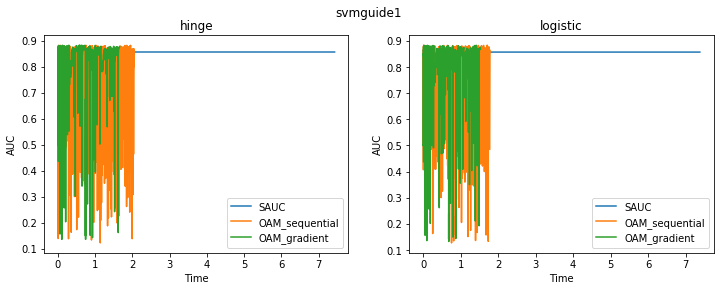

In [115]:
# Plot results
fig = plt.figure(figsize=(12, 4)) # create a figure object
fig.suptitle(dataset)

for name in NAME:
    for alg in ALG:
        ax = fig.add_subplot(1, len(NAME), NAME.index(name)+1)
        ax.set_title(name)
        if alg == 'SAUC':
            ax.plot(res[(name,alg)][0], res[(name,alg)][1], label = alg)
#             ax.plot(res[(name,alg)][1], label = alg)
        else:
            for option in OPTION:
                ax.plot(res[(name,alg+'_'+option)][0], res[(name,alg+'_'+option)][1], label = alg+'_'+option)
#                 ax.plot(res[(name,alg+'_'+option)][1], label = alg+'_'+option)
        ax.set_xlabel('Time')
        ax.set_ylabel('AUC')
        plt.legend(loc=4)
plt.show()